In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [3]:
# import pycbc.waveform # Waveforms

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/0f9d09/0f9d091579730f944829c2cd00d5501da9029cae


In [9]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import pycbcwaveform as pycbcwave
import plotparams


import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(pycbcwave)

import constants
imp.reload(constants)
from constants import *

# Code for making training set

In [3]:
def bns_merger_frequency(smallq, lambda1, lambda2):
    """lambda1 is for the more massive star.
    lambda2 is for the less massive star.
    smallq = m2/m1.
    This is the opposite notation as used in the Bernuzzi tidal EOB papers.
    This fit breaks down when q is significantly different from q=1.
    (q=0.5 is fine but the q=0 limit does not return the Schwarzschild ISCO limit.)
    Also probably not valid for lambda1 = lambda2 > 5000.
    """

    kappa = 3.0*( smallq*(1/(1+smallq))**5*lambda1 + smallq*(smallq/(1+smallq))**5*lambda2 )
    
    f0 = 0.360
    n1, n2, d1 = 2.59e-2, -1.28e-5, 7.49e-2
    momega22 = f0 * (1 + n1*kappa + n2*kappa**2) / (1.0 + d1*kappa)
    
    return momega22 / (2.0*np.pi)

In [52]:
# def dimensionless_td_waveform(q=1.0, 
#                               spin1x=0.0, spin1y=0.0, spin1z=0.0, 
#                               spin2x=0.0, spin2y=0.0, spin2z=0.0, 
#                               lambda1=0.0, lambda2=0.0,
#                               amplitude_order=-1, phase_order=-1, 
#                               mf_lower=0.001, delta_tbym=10.0, approximant='SpinTaylorT4'):
#     """Wrapper for pycbc waveforms to make them dimensionless.
#     Take dimensionless arguments and return dimensionless waveform.
    
#     Parameters
#     ----------
#     q : The small mass ratio q=m1/m2<=1 where m1 >= m2.
#     spin1x, spin1y, spin1z, lambda1 : Spins and tidal parameter of the more massive star m1.
#     spin2x, spin2y, spin2z, lambda2 : Spins and tidal parameter of the less massive star m2.
    
#     Returns
#     -------
#     h : Waveform
#     """
#     # dimensionless -> physical:
#     # Pick fiducial mtot = 1Msun and distance = 1Mpc
#     # pycbc expects units of Msun and Mpc
#     mtot = 1.0
#     distance = 1.0
#     inclination = 0.0
    
#     mass1 = mtot / (1.0 + q)
#     mass2 = mtot * q / (1.0 + q)
    
#     f_lower = C_SI**3 * mf_lower / (G_SI * MSUN_SI * mtot)
#     delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
    
#     hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, 
#                         mass1=mass1, mass2=mass2,
#                         spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
#                         spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
#                         lambda1=lambda1, lambda2=lambda2, 
#                         distance=distance, inclination=inclination,
#                         amplitude_order=amplitude_order, phase_order=phase_order, 
#                         delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
    
#     # Zero the start time and phase.
#     hphys = wave.Waveform.from_hp_hc(np.array(hp.sample_times), np.array(hp), np.array(hc))
#     hphys.add_x(-hphys.x[0])
#     hphys.add_phase(remove_start_phase=True)
    
#     # physical -> dimensionless:
#     return wave.physical_to_dimensionless_time(hphys, mtot, distance)


# def dimensionless_fd_waveform(q=1.0, 
#                               spin1x=0.0, spin1y=0.0, spin1z=0.0, 
#                               spin2x=0.0, spin2y=0.0, spin2z=0.0, 
#                               lambda1=0.0, lambda2=0.0,
#                               amplitude_order=-1, phase_order=-1, 
#                               mf_lower=0.001, delta_mf=1.0e-6, approximant='TaylorF2'):
#     """Wrapper for pycbc waveforms to make them dimensionless.
#     Take dimensionless arguments and return dimensionless waveform.
    
#     Parameters
#     ----------
#     q : The small mass ratio q=m1/m2<=1 where m1 >= m2.
#     spin1x, spin1y, spin1z, lambda1 : Spins and tidal parameter of the more massive star m1.
#     spin2x, spin2y, spin2z, lambda2 : Spins and tidal parameter of the less massive star m2.
    
#     Returns
#     -------
#     h : Waveform
#     """
#     # dimensionless -> physical:
#     # Pick fiducial mtot = 1Msun and distance = 1Mpc
#     # pycbc expects units of Msun and Mpc
#     mtot = 1.0
#     distance = 1.0
#     inclination = 0.0
    
#     # Remove sections of the waveform that have an amplitude below this threshold (e.g. beginning and end).
#     ampthresh = 1.0e-12
    
#     mass1 = mtot / (1.0 + q)
#     mass2 = mtot * q / (1.0 + q)
    
#     f_lower = C_SI**3 * mf_lower / (G_SI * MSUN_SI * mtot)
#     delta_f = C_SI**3 * delta_mf / (G_SI * MSUN_SI * mtot)
    
#     hp, hc = pycbc.waveform.get_fd_waveform(approximant=approximant, 
#                         mass1=mass1, mass2=mass2,
#                         spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
#                         spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
#                         lambda1=lambda1, lambda2=lambda2,
#                         distance=distance, inclination=inclination, 
#                         amplitude_order=amplitude_order, phase_order=phase_order, 
#                         delta_f=delta_f, f_lower=f_lower, f_ref=f_lower)

#     # Combine plus and cross polarizations: ~h(f) = ~h_+(f) + j ~h_x(f)
#     hphys = wave.Waveform.from_hp_hc(np.array(hp.sample_frequencies), np.array(hp), np.array(hc))
    
#     # physical -> dimensionless:
#     hdim =  wave.physical_to_dimensionless_freq(hphys, mtot, distance)
    
#     # Remove the start of the waveform that is just zeros
#     #iabove = np.searchsorted(hdim.x, mf_lower)
# #     iabove = np.searchsorted(hdim.amp, ampthresh)
# #     return wave.Waveform.from_amp_phase(hdim.x[iabove:], hdim.amp[iabove:], hdim.phase[iabove:])
#     i_nonzero = np.where(hdim.amp>ampthresh)
#     return wave.Waveform.from_amp_phase(hdim.x[i_nonzero], hdim.amp[i_nonzero], hdim.phase[i_nonzero])

In [53]:
# def plot_waveforms_fd(ax1, ax2, waveforms, xi=None, xf=None, npoints=1000):
#     """
#     """
#     for h in waveforms:
#         hcopy = h.copy()
#         wave.resample_uniform(hcopy, xi=xi, xf=xf, npoints=npoints, spacing='log', order=2)
        
#         ax1.plot(hcopy.x, hcopy.amp)
#         ax1.set_xscale('log')
#         #ax1.set_yscale('log')
        
#         ax2.plot(hcopy.x, hcopy.phase)
#         ax2.set_xscale('log')

In [54]:
###########################################################
## One thing you you could do to accurately unwrap the phase without
## insanely high sampling frequency, is fit out a linear piece 
## (possibly with known chirp term) to the scattered wrapped phase. 
## Then, unwrap the phase and add the linear fit back.
###########################################################

In [61]:
# def condition_uniform_waveform(h, tbym_tot, mfon_end, mfoff_start, mfoff_end, mftrunc_start):
#     """Generate a conditioned Frequency-domain waveform from a uniformly sampled time-domain waveform. 
#     1. Window the beginning and end.
#     2. Pad the end with zeros so all the waveforms in the training set have the exact same time samples.
#     3. Fourier transform the waveform.
#     4. Truncate the beginning of the Fourier transformed waveform to remove the start windowing effect.
    
#     Parameters
#     ----------
#     h : waveform
#         Uniformly sampled waveform.
#     tbym_tot : float
#         Total length of time domain waveform. Padded with zeros after merger.
#         (End time - start time)
#     mfon_end : float
#         Frequency when the on windowing stops. 
#         (The on windowing starts at the first data point corresponding to mf_lower.)
#     mfoff_start : float
#         Frequency when the off windowing starts.
#     mfoff_end : float
#         Frequency when the off windowing ends.
#     mftrunc_strat : float
#         Truncate the Fourier transformed waveform below this frequency.
#         (A reasonable choice is the same as mfon_end.)
#     """    
#     # Get data about the waveforms
#     n_data = len(h.x)
#     delta_tbym = h.x[1]-h.x[0]
    
#     # 1. Window the waveform
#     h = wave.window_waveform_in_frequency_interval(h, mfon_end, mfoff_start, mfoff_end)
    
#     ##### 2. Extend the waveform #####
    
#     # Set new times
#     times_ext = h.x[0] + np.arange(0.0, tbym_tot, delta_tbym)
#     n_ext = len(times_ext)
#     # Set new amplitude
#     amp_ext = np.zeros(n_ext)
#     amp_ext[:n_data] = h.amp
#     # Set new phase
#     # (Make phase continuous even when amplitude goes to zero)
#     phase_ext = np.ones(n_ext)*h.phase[-1]
#     phase_ext[:n_data] = h.phase
    
#     h_ext = wave.Waveform.from_amp_phase(times_ext, amp_ext, phase_ext)
    
#     # 3. Fourier transform
#     htilde = wave.fourier_transform_waveform(h_ext, delta_tbym)
    
#     # 4. Truncate waveform
#     htrunc = train.truncate_beginning(htilde, mftrunc_start, remove_start_phase=True)
    
#     # 5. TODO: You could also truncate the end if you want. Or, leave 4 and 5 outside this function.
    
#     return htrunc

In [10]:
# def fit_time_phase_shift(h, href, mffit_start, mffit_end, nsamp=100):
#     """Fit the difference phase-phase_ref in the interval (mffit_start, mffit_end).
    
#     Returns
#     -------
#     shifted_phase : array
#         Array to add to apply the time and phase shift in the frequency domain.
#     """
#     # Data to fit a line to
#     mfs = np.linspace(mffit_start, mffit_end, nsamp)
#     phase = h.interpolate('phase')(mfs)
#     phase_ref = href.interpolate('phase')(mfs)
#     phase_diff = phase - phase_ref
        
#     # The linear model
#     def line_fit(x, a, b):
#         return a + b*x
    
#     # Do the least squares fit
#     coeffs, covariances = optimize.curve_fit(line_fit, mfs, phase_diff)
    
#     shifted_phase = h.phase - line_fit(h.x, *coeffs)
#     hshifted = h.copy()
#     hshifted.phase = shifted_phase
#     return hshifted

In [11]:
# def lnamp_phase_difference(h1, h2, npoints=1000, spacing='linear', order=2):
#     """Evaluate lnA_1(x)-lnA_2(x) and Phi_1(x)-Phi_2(x).
    
#     Parameters
#     ----------
#     h1, h2 : Waveform
#     npoints : int, optional
#         Number of evenly spaced points at which to evaluate phase difference
    
#     Returns
#     -------
#     Waveform
#     """
#     # Bounds [xi, xf] are the minimum and maximum values of x the two waveforms have in common.
#     xi = max(h1.x[0], h2.x[0])
#     xf = min(h1.x[-1], h2.x[-1])
#     if spacing == 'linear':
#         xs = np.linspace(xi, xf, npoints)
#     elif spacing == 'log':
#         xs = np.logspace(np.log10(xi), np.log10(xf), npoints)
#     else:
#         raise Exception, "Valid 'spacing' options: 'linear', 'log'."

#     h1lnamp = h1.interpolate('amp', order=order)(xs)
#     h2lnamp = h2.interpolate('amp', order=order)(xs)
#     h1phase = h1.interpolate('phase', order=order)(xs)
#     h2phase = h2.interpolate('phase', order=order)(xs)
    
#     dlnamp = np.log(h1lnamp) - np.log(h2lnamp)
#     dphase = h1phase - h2phase
#     return wave.Waveform.from_amp_phase(xs, dlnamp, dphase)

In [181]:
# # kwargs is a dictionary ({key : value} pairs)
# # **kwargs unpacks this dictionary and returns keyword arguments to a function
# def get_td_vs_fd_waveform(mf_lower, delta_tbym, tbym_tot, mfon_end, mfoff_start, mfoff_end, 
#                                     mftrunc_start, href_delta_mf, mffit_start, mffit_end, ndownsample=1000, 
#                                     htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2', **kwargs):
#     """Generate a time-domain waveform and compare it to a frequency-domain waveform.
    
    
#     Returns
#     -------
#     hfshifted : Waveform
#         TD waveform after Conditioning, Fourier transforming, and matching at beginning to FD waveform.
#     hfref : Waveform
#         FD reference waveform
#     dhf : Waveform
#         lnA_TD(Mf)-lnA_FD(Mf) and Phi_TD(Mf)-Phi_FD(Mf) stored in the 'amp' and 'phase' arrays.
#     """
#     ########### Calculate time-domain waveform and condition it in the frequency domain ############
# #     ht = dimensionless_td_waveform(mf_lower=mf_lower, delta_tbym=delta_tbym, approximant=htapproximant, **kwargs)
#     ht = dimensionless_td_waveform(mf_lower=mf_lower, delta_tbym=delta_tbym, approximant=htapproximant, 
#                                    amplitude_order=-1, **kwargs)
#     hfcond = condition_uniform_waveform(ht, tbym_tot, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
#     wave.resample_uniform(hfcond, npoints=ndownsample, spacing='log', order=2)
    
#     ########### Calculate reference frequency domain waveform #############
#     # Zero the waveform parameters that aren't allowed in a specific waveform approximant
#     if hfrefapproximant=='IMRPhenomP':
#         kwargs['lambda1'] = kwargs['lambda2'] = 0.0
#     if hfrefapproximant=='TaylorF2':
#         kwargs['spin1x'] = kwargs['spin1y'] = kwargs['spin2x'] = kwargs['spin2y'] = 0.0
#     hfref = dimensionless_fd_waveform(mf_lower=mf_lower, delta_mf=href_delta_mf, approximant=hfrefapproximant, **kwargs)
#     wave.resample_uniform(hfref, npoints=ndownsample, spacing='log', order=2)
    
#     # Shift the waveform to match the reference waveform
#     hfshifted = fit_time_phase_shift(hfcond, hfref, mffit_start, mffit_end, nsamp=1000)
    
#     # Calculate the lnamp and phase differences
#     dhf = lnamp_phase_difference(hfshifted, hfref, npoints=ndownsample, spacing='log', order=2)
    
#     # Make 3 separate WaveformSet objects that contain lists of hfref, hfshifted, dh
#     #return ht, hfcond, hfshifted, hfref, dhf
#     return hfshifted, hfref, dhf

In [182]:
# def make_td_vs_fd_waveform_set(filename, params, 
#                                mf_lower, delta_tbym, tbym_tot, 
#                                mfon_end, mfoff_start, mfoff_end, 
#                                mftrunc_start, 
#                                href_delta_mf, 
#                                mffit_start, mffit_end,
#                                htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2'):
#     """Make a WaveformSet containing waveforms with parameters params.
#     """
#     ts = ws.HDF5WaveformSet(filename)
    
#     for i in range(len(params)):
#         print i,
#         p = params[i]
#         q, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, lambda1, lambda2 = p
#         hfshifted, hfref, dhf = get_td_vs_fd_waveform(mf_lower, delta_tbym, tbym_tot, 
#                                     mfon_end, mfoff_start, mfoff_end, 
#                                     mftrunc_start, 
#                                     href_delta_mf, 
#                                     mffit_start, mffit_end, 
#                                     ndownsample=1000,
#                                     htapproximant=htapproximant, hfrefapproximant=hfrefapproximant,
#                                     q=q, 
#                                     spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
#                                     spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
#                                     lambda1=lambda1, lambda2=lambda2)
#         ts.set_waveform(i, dhf, p)

#     return ts

# Code for Gaussian Process

In [175]:
# def generate_square_exponential_gp(params, data, hp0, limits, n_restarts_optimizer=9):
#     """
#     """
#     # The constant term is sigma_f**2, but the parameter that you want to give it is sigma_f
#     const = ConstantKernel(hp0[0]**2, limits[0]**2)
#     # Length scales l_i (not l_i**2)
#     sqexp = RBF(hp0[1:-1], limits[1:-1])
#     # Noise term sigma_n (not sigma_n**2)
#     noise = WhiteKernel(hp0[-1], limits[-1])
#     kernel = const*sqexp + noise
    
#     # Initialize the Gaussian Process
#     gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)
    
#     # Optimize the hyperparameters by maximizing the log likelihood
#     gp.fit(params, data)
    
#     return gp

# Make validation and training sets

In [4]:
# These parameters work for ISCO frequency:
mf_lower = 0.0008
delta_tbym = 10.0

tbym_tot = 3.0e6
mfon_end = 0.001
mfoff_start = 0.015
mfoff_end = 0.020
mftrunc_start = mfon_end

href_delta_mf = 5.0e-7

ndownsample = 1000

mffit_start = 0.001
mffit_end = 0.0012

In [16]:
# Parameters for the training set
Ndata = 10
limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
p_sub = gpr.latin_hypercube(Ndata, limits)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_training_set.hdf5'

trainset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')

trainset.close()

 0 1 2 3 4 5 6 7 8 9


In [17]:
# Generate the validation set
q = 0.6
spin2z = 0.3
lambda1 = 2000.0
lambda2 = 1000.0
s1zs = np.linspace(-0.4, 0.4, 11)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[q, spin1x, spin1y, s1z, spin2x, spin2y, spin2z, lambda1, lambda2] for s1z in s1zs])

filename = '../data/aligned_validation_set.hdf5'

validset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
validset.close()

0 1 2 3 4 5 6 7 8 9 10


In [18]:
# Generate the randomly sampled set
Ndata = 10
limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
p_sub = gpr.uniform_random_samples(Ndata, limits)

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0
params = np.array([[p_sub[i, 0], spin1x, spin1y, p_sub[i, 1], spin2x, spin2y, p_sub[i, 2], 
                    p_sub[i, 3], p_sub[i, 4]] for i in range(len(p_sub))])

filename = '../data/aligned_rand_set.hdf5'

randset = train.make_td_vs_fd_waveform_set(filename, params, 
                               mf_lower, delta_tbym, tbym_tot, 
                               mfon_end, mfoff_start, mfoff_end, 
                               mftrunc_start, 
                               href_delta_mf, 
                               mffit_start, mffit_end,
                               htapproximant='SpinTaylorT4', hfrefapproximant='TaylorF2')
randset.close()

0 1 2 3 4 5 6 7 8 9


# Now open WaveformSets and use them

In [19]:
trainset = ws.HDF5WaveformSet('../data/aligned_training_set.hdf5')
validset = ws.HDF5WaveformSet('../data/aligned_validation_set.hdf5')
randset = ws.HDF5WaveformSet('../data/aligned_rand_set.hdf5')

(0.0001, 0.1)

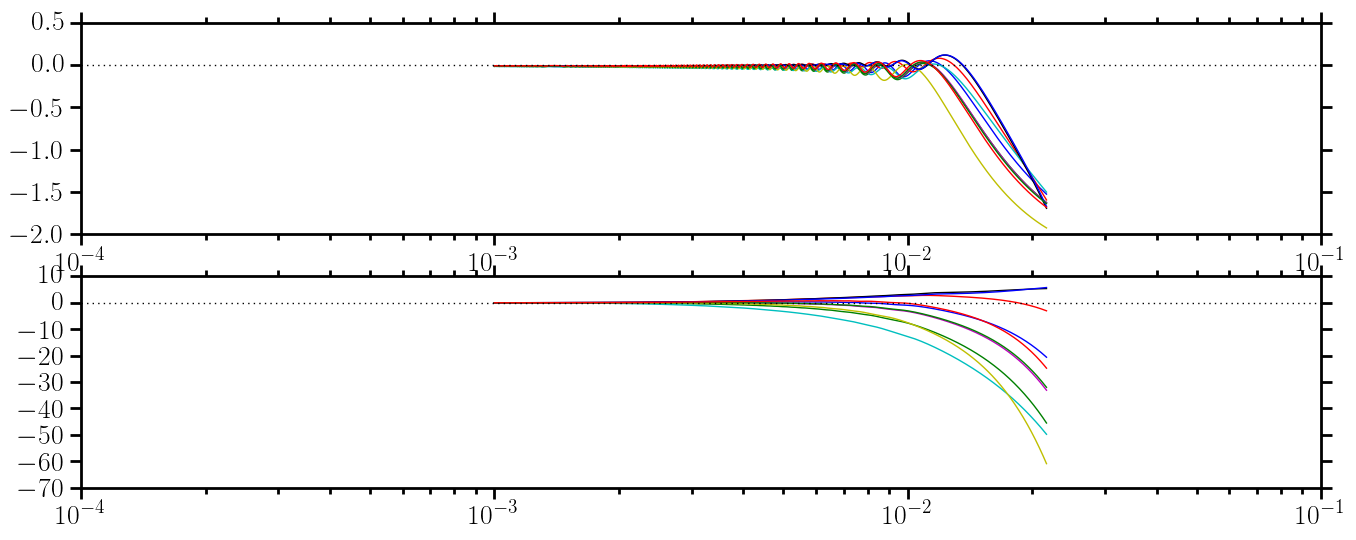

In [21]:
hs = [trainset[i] for i in range(len(trainset))]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

(0.0001, 0.1)

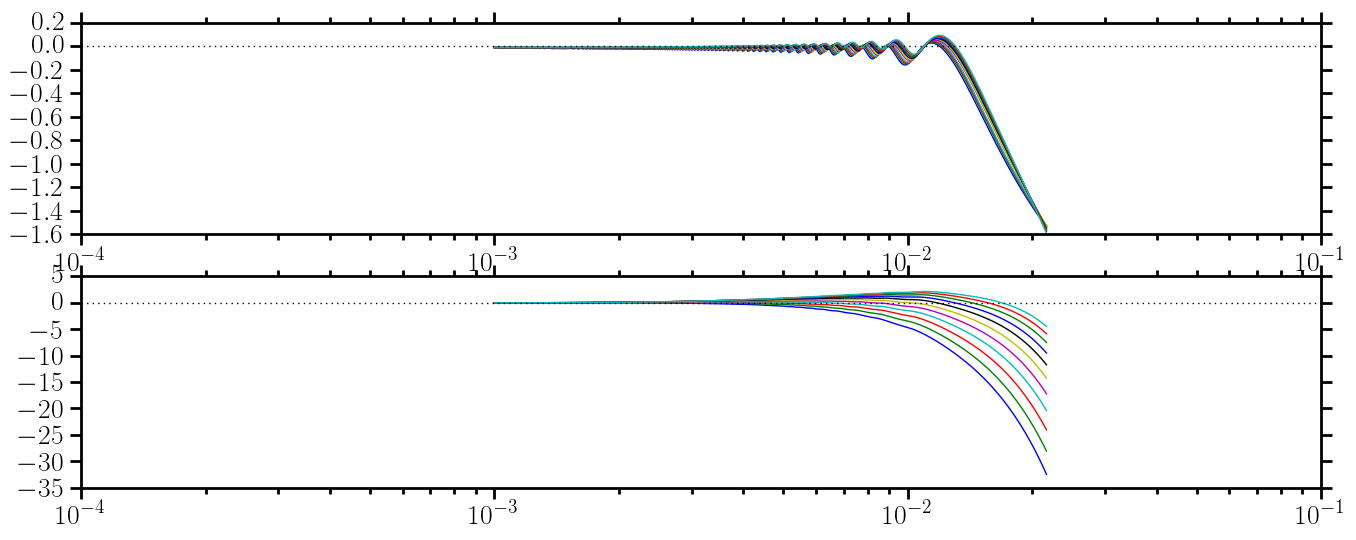

In [22]:
hs = [validset[i] for i in range(len(validset))]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

(0.0001, 0.1)

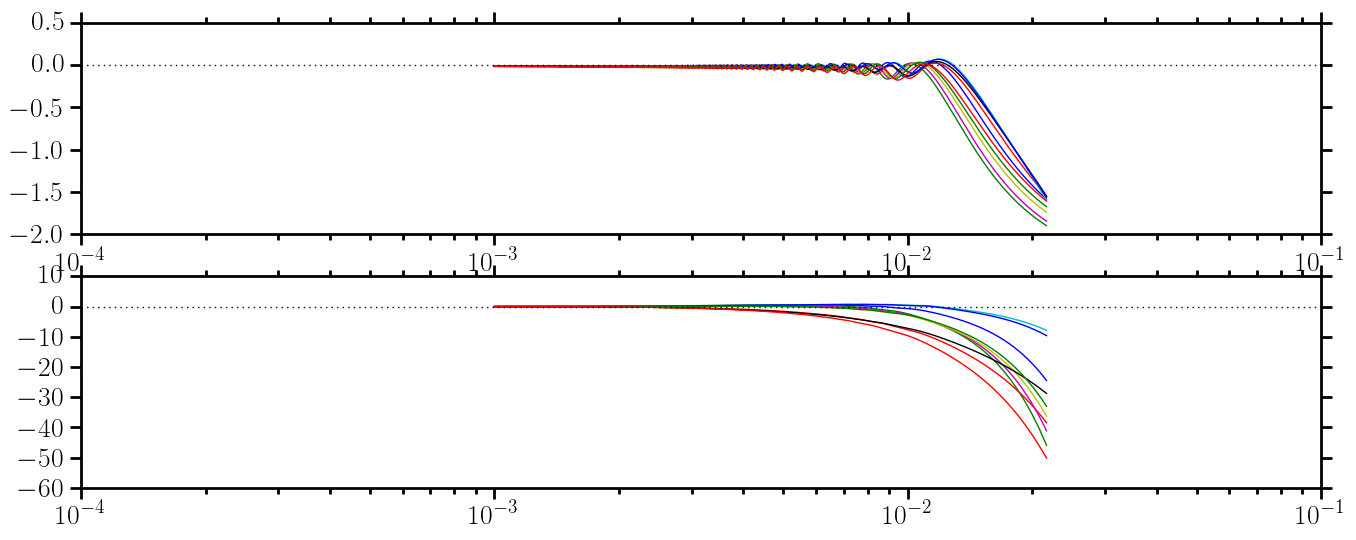

In [23]:
hs = [randset[i] for i in range(len(randset))]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
wave.plot_waveforms_fd(ax1, ax2, hs)
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_xlim(1.0e-4, 0.1)
ax2.set_xlim(1.0e-4, 0.1)

0.02 1450.18173941


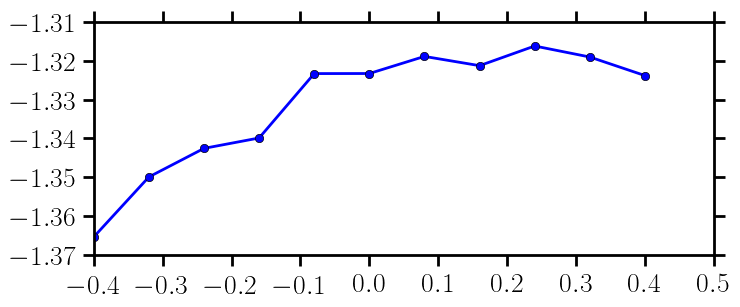

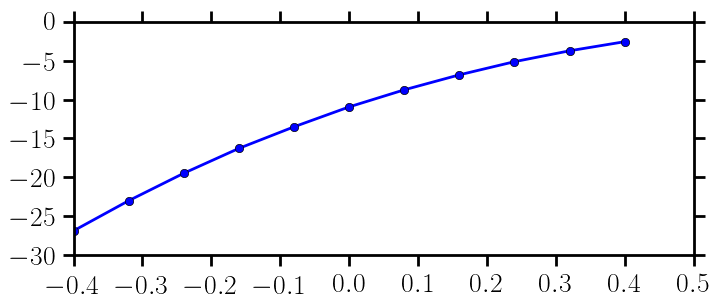

In [63]:
mf = 0.02
print mf, mf_to_f(mf, 2.8)

amps = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)


phis = []
ps = []
for i in range(len(validset)):
    h = validset[i]
    p = validset.get_waveform(i, data='parameters')[3]
    phi = h.interpolate('phase')(mf)
    ps.append(p)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phis, 'o', ls='-', lw=2)

# Generate Gaussian processes

In [64]:
###### Could also try reparameterizing the grid with the measurable quantities:
# mchirp/mtot = eta^{3/5}?, f(eta, chi_eff), chi_a, tilde_lambda, delta_tilde_lambda
# Use the same points, but reparameterize (no longer on rectangular grid) before generating gp.
# This way the length scale parameters will be more aligned with the principal components.

nsamp = 50

params_ts = trainset.parameters()[:, [0, 3, 6, 7, 8]]

mfs = np.logspace(np.log10(trainset[0].x[0]), np.log10(trainset[0].x[-1]), nsamp)
#mfs = np.logspace(np.log10(trainset[0].x[0]), 0.02, nsamp)

damp_ts_list = []
dphase_ts_list = []
for j in range(len(mfs)):
    mf = mfs[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    dphase_ts_list.append(dphase_ts)

In [65]:
# Generate list of damp GPs at each frequency in mfs
hp0 = np.array([0.5, 0.5, 0.4, 0.4, 5000.0, 5000.0, 0.1])
limits = np.array([[0.01, 100], [0.1, 100], [0.1, 100], [0.1, 100], [100, 50000], [100, 50000], [0.00001, 1.0]])

damp_gp_list = []
for i in range(len(damp_ts_list)):
    damp_gp = gpr.generate_square_exponential_gp(params_ts, damp_ts_list[i], hp0, limits, n_restarts_optimizer=9)
    damp_gp_list.append(damp_gp)

In [66]:
# Generate list of dphase GPs at each frequency in mfs
hp0 = np.array([5.0, 0.5, 0.4, 0.4, 5000.0, 5000.0, 0.1])
limits = np.array([[0.0001, 500], [0.1, 100], [0.1, 100], [0.1, 100], [100, 100000], [100, 100000], [0.00001, 1.0]])

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    dphase_gp = gpr.generate_square_exponential_gp(params_ts, dphase_ts_list[i], hp0, limits, n_restarts_optimizer=9)
    dphase_gp_list.append(dphase_gp)

0.00175920988236


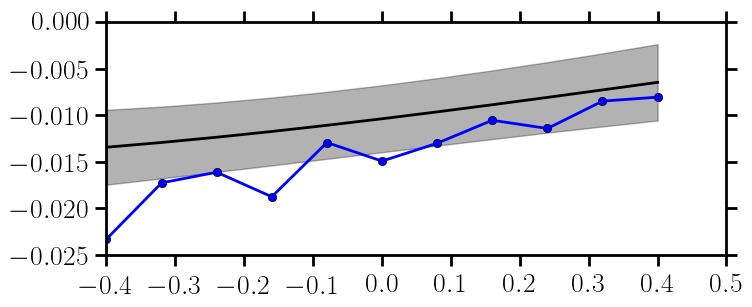

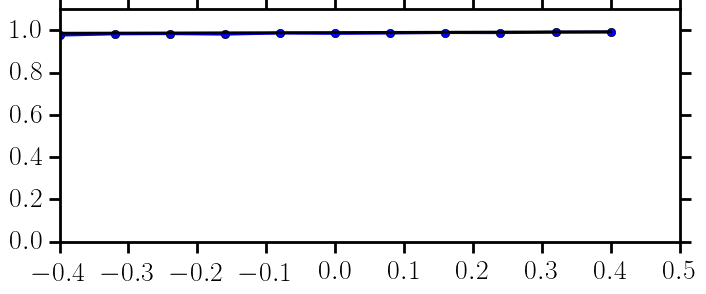

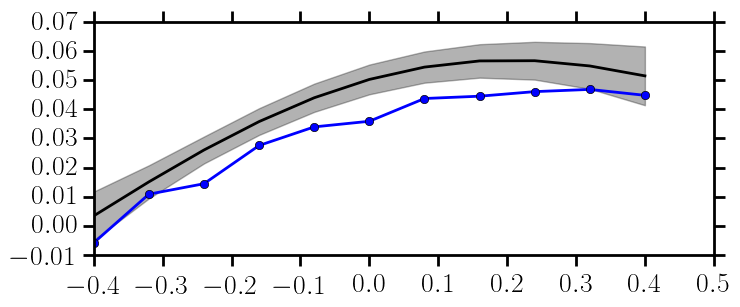

In [67]:
i = 9
mf = mfs[i]
print mf

params_vs = validset.parameters()[:, [0, 3, 6, 7, 8]]

damp_vs = np.array([validset[j].interpolate('amp')(mf) for j in range(len(validset))])
dphase_vs = np.array([validset[j].interpolate('phase')(mf) for j in range(len(validset))])

damp_gp = damp_gp_list[i]
dphase_gp = dphase_gp_list[i]

damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_vs, return_std=True)
dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_vs, return_std=True)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], damp_vs, 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], damp_gp_eval, ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, color='k', alpha=0.3)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], np.exp(damp_vs), 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], np.exp(damp_gp_eval), ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], np.exp(damp_gp_eval-damp_gp_eval_err), np.exp(damp_gp_eval+damp_gp_eval_err), color='k', alpha=0.3)
axes.set_ylim(0, 1.1)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params_vs[:, 1], dphase_vs, 'o', ls='-', lw=2)
axes.plot(params_vs[:, 1], dphase_gp_eval, ls='-', lw=2, c='k')
axes.fill_between(params_vs[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, color='k', alpha=0.3)

# Reconstruct waveform and compare with validation sets

In [68]:
def reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list):
    """
    """
    params_2d = np.atleast_2d(params)
    damp = []
    damp_err = []
    dphase = []
    dphase_err = []
    for i in range(len(mfs)):
        damp_gp = damp_gp_list[i]
        dphase_gp = dphase_gp_list[i]
        
        damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_2d, return_std=True)
        dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_2d, return_std=True)
        
        damp.append(damp_gp_eval[0])
        damp_err.append(damp_gp_eval_err[0])
        dphase.append(dphase_gp_eval[0])
        dphase_err.append(dphase_gp_eval_err[0])
    
    dh = wave.Waveform.from_amp_phase(np.array(mfs), np.array(damp), np.array(dphase))
    dh_err = wave.Waveform.from_amp_phase(np.array(mfs), np.array(damp_err), np.array(dphase_err))
    return dh, dh_err

In [69]:
def plot_waveforms_fd_comparison(ax1, ax2, htrue, hgp, hgp_err, exp=False):
    """
    """
    htrue_c = htrue.copy()
    hgp_c = hgp.copy()
    hgp_err_c = hgp_err.copy()
    wave.resample_uniform(htrue_c, spacing='log', order=2)
    wave.resample_uniform(hgp_c, spacing='log', order=2)
    wave.resample_uniform(hgp_err_c, spacing='log', order=2)

    if exp==False:
        ax1.plot(htrue_c.x, htrue.amp)
        ax1.plot(hgp_c.x, hgp_c.amp)
        ax1.plot(hgp.x, hgp.amp, 'o')
        ax1.fill_between(hgp_err_c.x, hgp_c.amp-hgp_err_c.amp, hgp_c.amp+hgp_err_c.amp, 
                         color='k', alpha=0.3)
    else:
        ax1.plot(htrue_c.x, np.exp(htrue.amp))
        ax1.plot(hgp_c.x, np.exp(hgp_c.amp))
        ax1.plot(hgp.x, np.exp(hgp.amp), 'o')
        ax1.fill_between(hgp_err_c.x, np.exp(hgp_c.amp-hgp_err_c.amp), np.exp(hgp_c.amp+hgp_err_c.amp), 
                         color='k', alpha=0.3)
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
        
    ax2.plot(htrue_c.x, htrue.phase)
    ax2.plot(hgp_c.x, hgp_c.phase)
    ax2.plot(hgp.x, hgp.phase, 'o')
    ax2.fill_between(hgp_err_c.x, hgp_c.phase-hgp_err_c.phase, hgp_c.phase+hgp_err_c.phase, 
                     color='k', alpha=0.3)
    ax2.set_xscale('log')

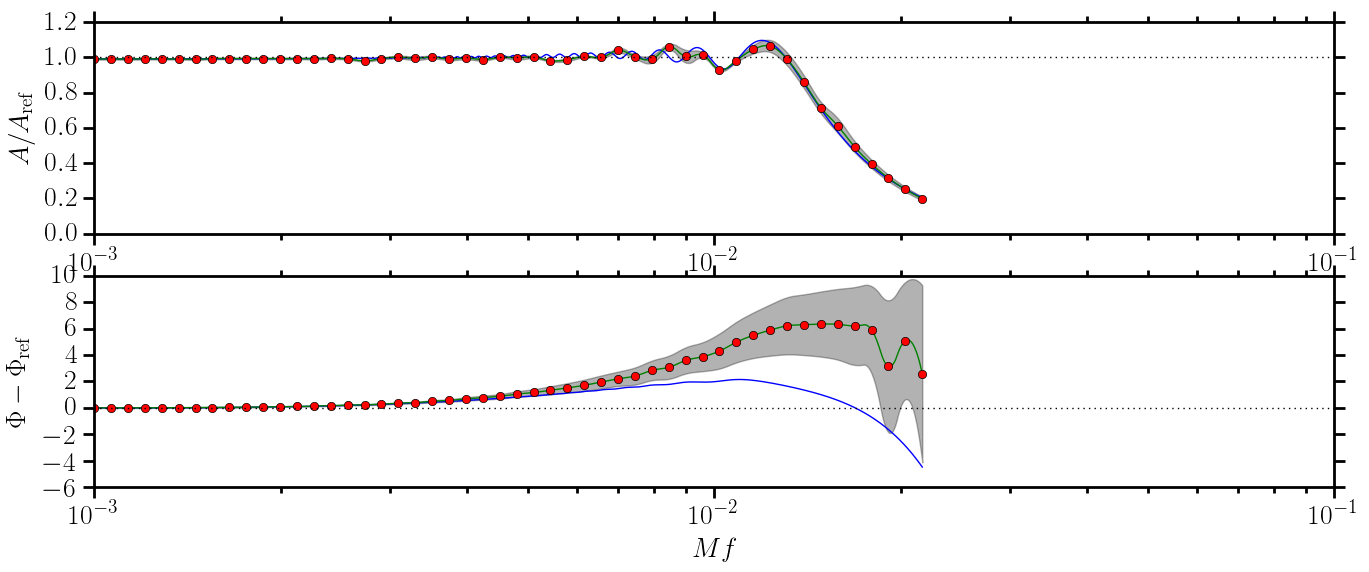

In [70]:
i = 10
hv = validset[i]
params = validset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
plot_waveforms_fd_comparison(ax1, ax2, hv, dh, dh_err, exp=True)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
# ax1.set_ylabel(r'$\ln(A/A_{\rm ref})$')
ax1.set_ylabel(r'$A/A_{\rm ref}$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm ref}$')
ax2.set_xlabel(r'$Mf$')

[  7.24617989e-01  -3.61746945e-01  -1.42137429e-01   2.77147141e+03
   1.18658072e+03]


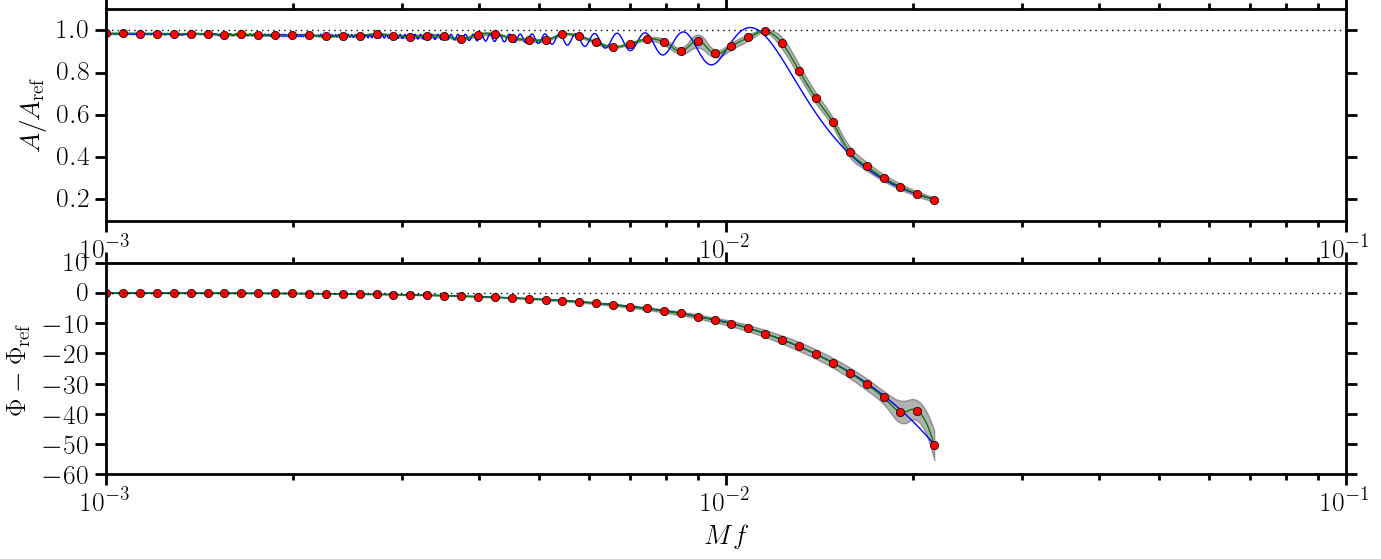

In [71]:
i = 9
hv = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
plot_waveforms_fd_comparison(ax1, ax2, hv, dh, dh_err, exp=True)
ax1.axhline(1, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
# ax1.set_ylabel(r'$\ln(A/A_{\rm ref})$')
ax1.set_ylabel(r'$A/A_{\rm ref}$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm ref}$')
ax2.set_xlabel(r'$Mf$')

In [72]:
i = 0
hv = randset[i]
params = randset.get_waveform(i, data='parameters')[[0, 3, 6, 7, 8]]
print params
dh, dh_err = reconstruct_amp_phase_difference(params, mfs, damp_gp_list, dphase_gp_list)

amp_err_at_nodes = np.exp(dh.amp-hv.interpolate('amp')(mfs))-1
phase_err_at_nodes = dh.phase-hv.interpolate('phase')(mfs)

amp_err = np.exp(dh.interpolate('amp')(hv.x)-hv.interpolate('amp')(hv.x))-1
phase_err = dh.interpolate('phase')(hv.x)-hv.interpolate('phase')(hv.x)

[  5.27472185e-01   1.46143054e-01   1.60476142e-01   2.83247302e+03
   6.79496853e+02]


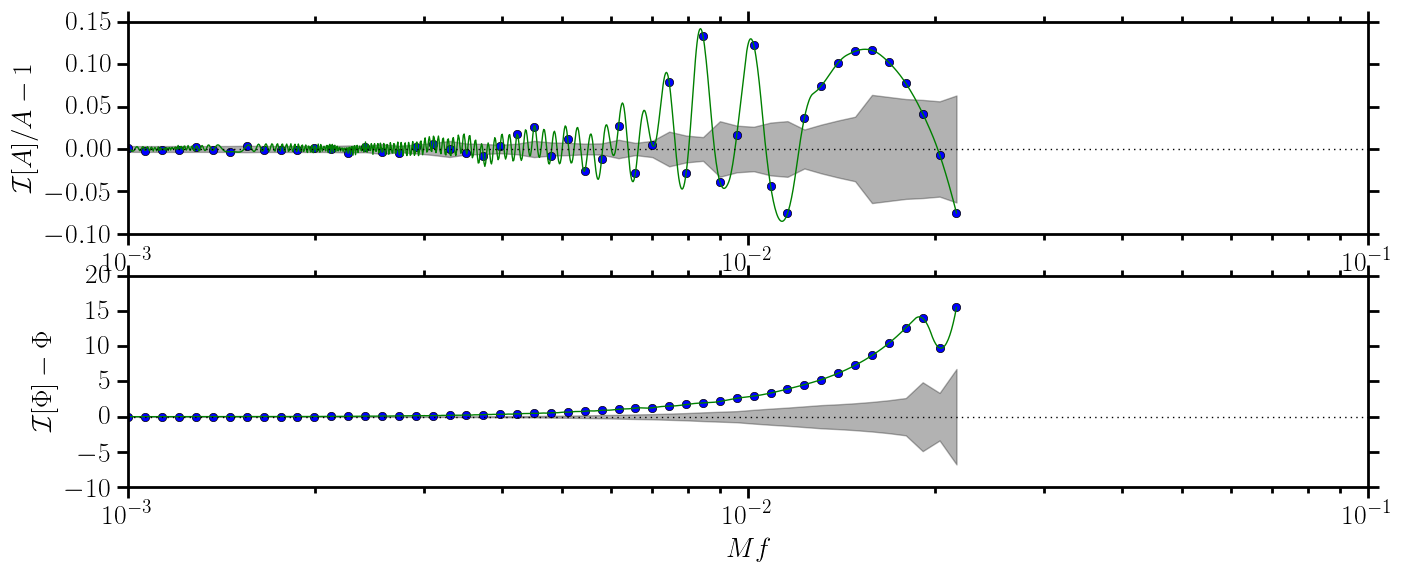

In [73]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 6))
ax1.plot(mfs, amp_err_at_nodes, 'o')
ax1.fill_between(dh_err.x, -dh_err.amp, dh_err.amp, color='k', alpha=0.3)
ax1.plot(hv.x, amp_err)

ax2.plot(mfs, phase_err_at_nodes, 'o')
ax2.fill_between(dh_err.x, -dh_err.phase, dh_err.phase, color='k', alpha=0.3)
ax2.plot(hv.x, phase_err)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.axhline(0, ls=':', c='k', lw=1)
ax2.axhline(0, ls=':', c='k', lw=1)
ax1.set_ylabel(r'$\mathcal{I}[A]/A-1$')
ax2.set_ylabel(r'$\mathcal{I}[\Phi]-\Phi$')
ax2.set_xlabel(r'$Mf$')

# Old

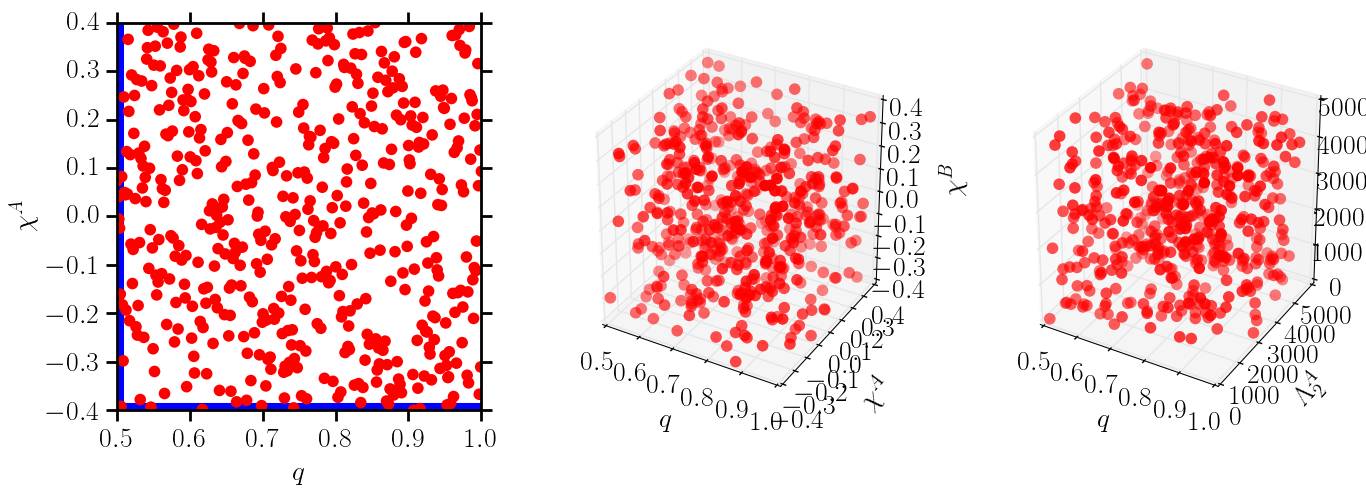

In [41]:
points = params

# ******* plot data *******
fig = plt.figure(figsize=(16, 5))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(131)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\chi^A$')
#axes.set_ylabel(r'$\Lambda_2^A$')


# ****** Full 3d data ******
axes = fig.add_subplot(132, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$\chi^A$', labelpad=15)
axes.set_zlabel(r'$\chi^B$', labelpad=18)
# axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
# axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

axes = fig.add_subplot(133, projection='3d')

x, y, z = points[:, 0], points[:, 3], points[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[3])
axes.set_zlim(limits[4])
axes.set_xlabel(r'$q$', labelpad=10)
# axes.set_ylabel(r'$\chi_2^A$', labelpad=15)
# axes.set_zlabel(r'$\chi_2^B$', labelpad=18)
axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

In [122]:
def max_error_2d_projection_plot(axes, x, y, error, x_label='x', y_label='y', colorbar=None, colorbarlabel='error'):
    
    # Sort errors so largest errors are plotted on top of smaller errors
    error_params = np.array([error, x, y]).T
    error_params_sort = error_params[error_params[:, 0].argsort()]
    error_max = error_params_sort[-1, 0]
    
    # Scatter plot with colorbar
    sc = axes.scatter(error_params_sort[:, 1], error_params_sort[:, 2], 
                      c=error_params_sort[:, 0], s=100*error_params_sort[:, 0]/error_max,
                      edgecolor='', alpha=1.0)
        
    if colorbar:
        cb = plt.colorbar(mappable=sc, ax=axes)
        cb.set_label(label=colorbarlabel, fontsize=18)
        cb.ax.tick_params(labelsize=14)

    # buffers for plot
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    bufx = 0.05*(xmax - xmin)
    bufy = 0.05*(ymax - ymin)
    
    axes.set_xlim([xmin-bufx, xmax+bufx])
    axes.set_ylim([ymin-bufy, ymax+bufy])
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.minorticks_on()

In [123]:
def error_1d_projection(x, error, error_type='max', xmin=None, xmax=None, nbins=10):
    """
    """
    if xmin==None: xmin = x.min()
    if xmax==None: xmax = x.max()

    bin_edges = np.linspace(xmin, xmax, nbins+1)
    
    # Find which bin each data point is in
    bini = np.digitize(x, bin_edges)
    
    # Find the maximum error in each bin
    error_stat = []
    for i in range(1, len(bin_edges)):
        # errors from bin_edges[i-1] <= x <= bin_edges[i]
        errors_in_bin = error[bini==i]
        if len(errors_in_bin)==0:
            error_stat.append(0.0)
        else:
            if error_type=='max':
                error_stat.append(np.max(errors_in_bin))
            elif error_type=='mean':
                error_stat.append(np.mean(errors_in_bin))
        
    return bin_edges, np.array(error_stat)

In [124]:
def error_1d_projection_plot(axes, x, error, error_type='max', xmin=None, xmax=None, nbins=10, **kwargs):
    """
    """
    bin_edges, max_error = error_1d_projection(x, error, error_type=error_type, xmin=xmin, xmax=xmax, nbins=nbins)
    axes.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), max_error, **kwargs)

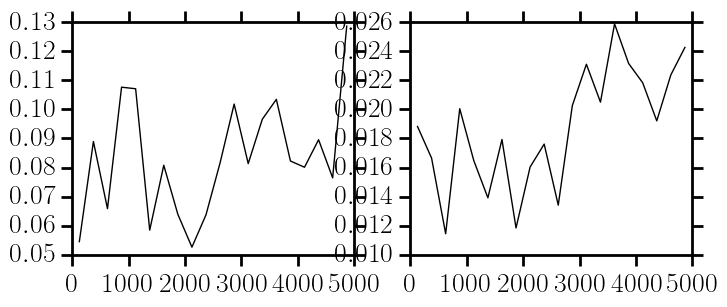

In [125]:
x = params_rand[:, 4]
error = np.abs(phase_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
error_1d_projection_plot(ax1, x, error, error_type='max', nbins=20, c='k')
error_1d_projection_plot(ax2, x, error, error_type='mean', nbins=20, c='k')

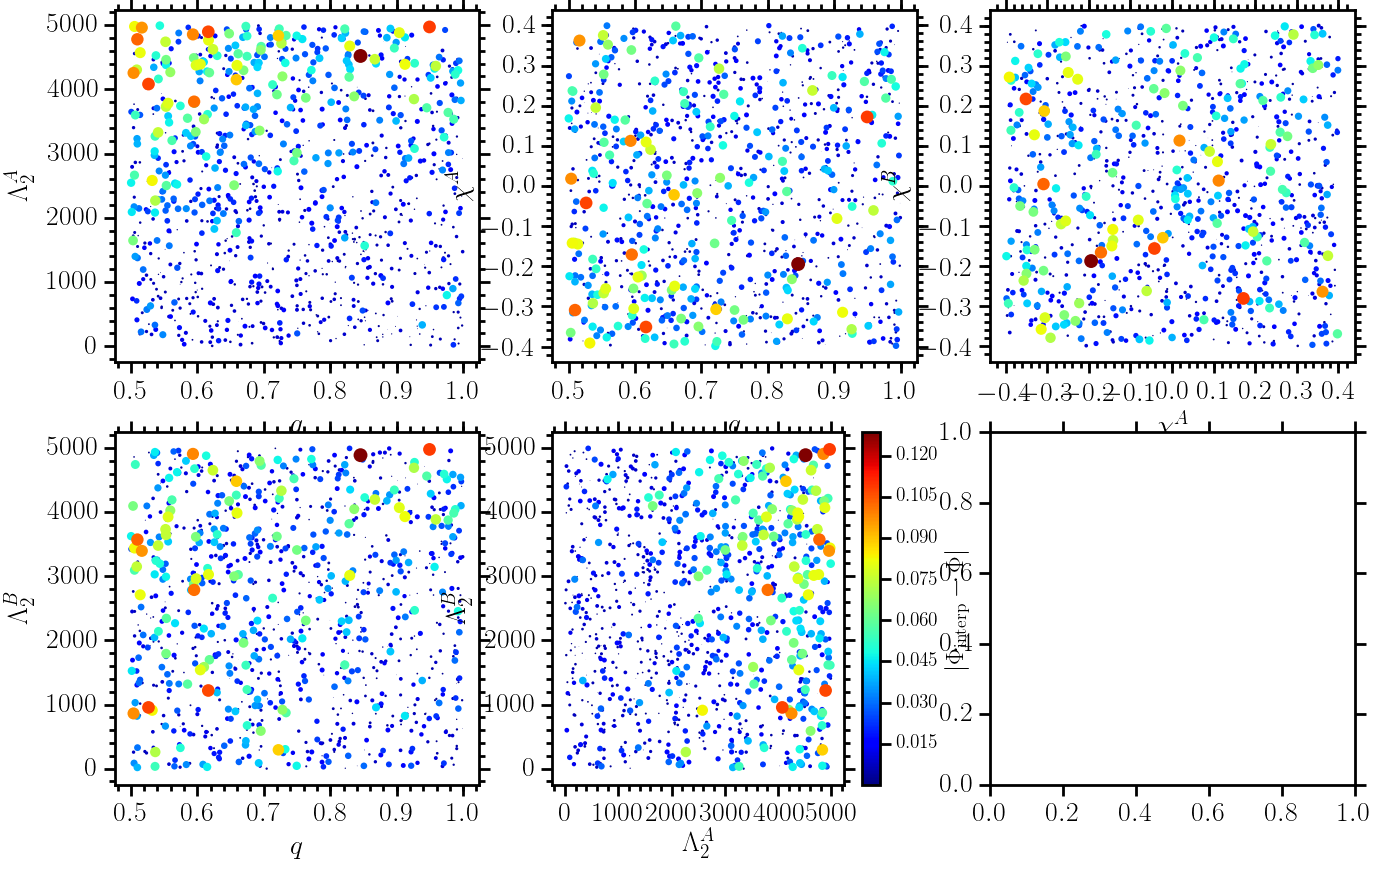

In [126]:
error = np.abs(phase_err)
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

x = params_rand[:, 0]
y = params_rand[:, 3]
max_error_2d_projection_plot(ax[0, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^A$', colorbar=None)

x = params_rand[:, 0]
y = params_rand[:, 1]
max_error_2d_projection_plot(ax[0, 1], x, y, error, x_label=r'$q$', y_label=r'$\chi^A$', colorbar=None)

x = params_rand[:, 1]
y = params_rand[:, 2]
max_error_2d_projection_plot(ax[0, 2], x, y, error, x_label=r'$\chi^A$', y_label=r'$\chi^B$', colorbar=None)

x = params_rand[:, 0]
y = params_rand[:, 4]
max_error_2d_projection_plot(ax[1, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^B$', colorbar=None)

x = params_rand[:, 3]
y = params_rand[:, 4]
max_error_2d_projection_plot(ax[1, 1], x, y, error, x_label=r'$\Lambda_2^A$', y_label=r'$\Lambda_2^B$', colorbar=True, 
                             colorbarlabel=r'$|\Phi_{\rm interp}-\Phi|$')

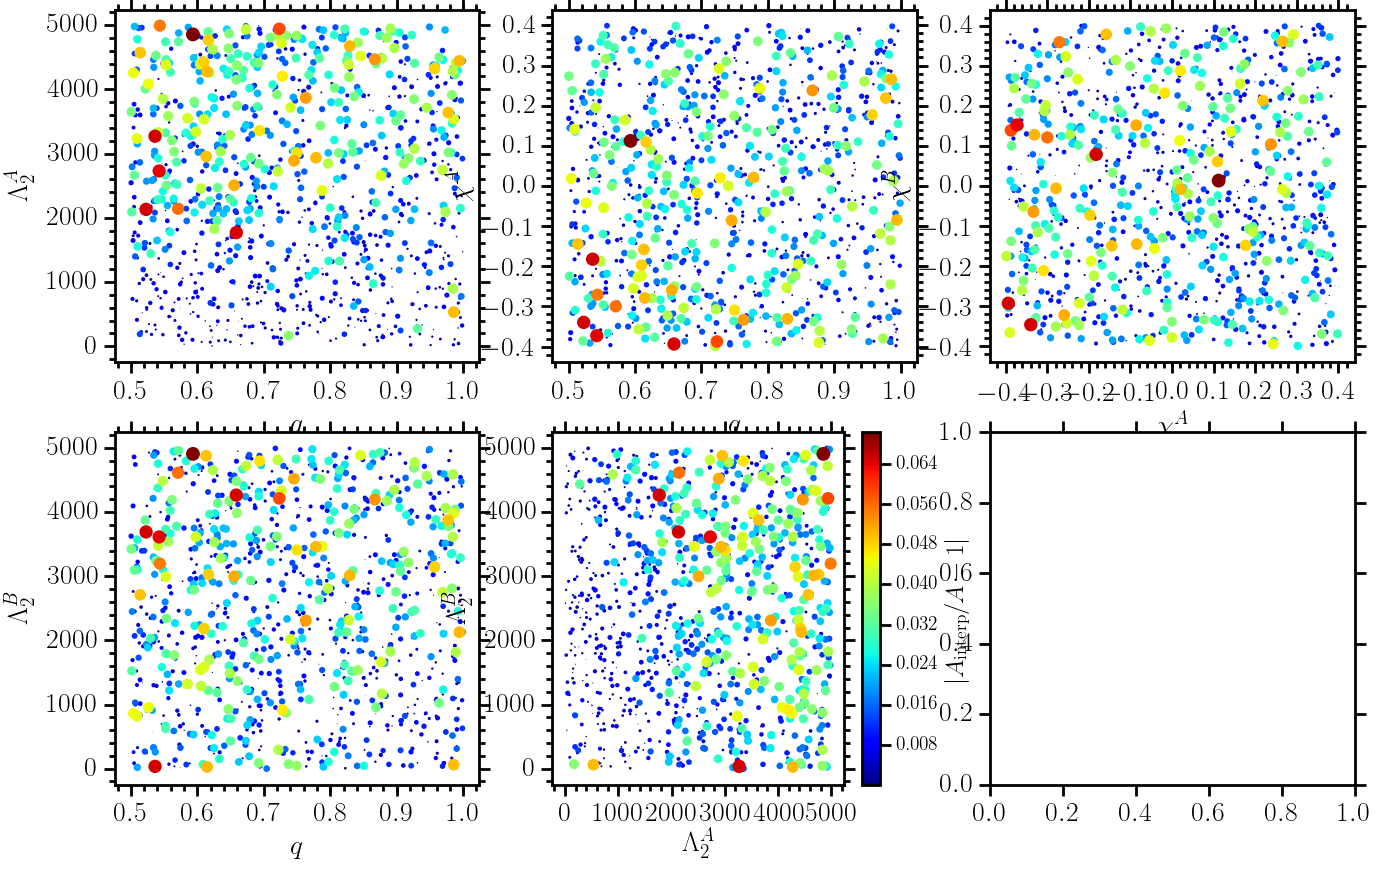

In [127]:
error = np.abs(amp_err)
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

x = params_rand[:, 0]
y = params_rand[:, 3]
max_error_2d_projection_plot(ax[0, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^A$', colorbar=None)

x = params_rand[:, 0]
y = params_rand[:, 1]
max_error_2d_projection_plot(ax[0, 1], x, y, error, x_label=r'$q$', y_label=r'$\chi^A$', colorbar=None)

x = params_rand[:, 1]
y = params_rand[:, 2]
max_error_2d_projection_plot(ax[0, 2], x, y, error, x_label=r'$\chi^A$', y_label=r'$\chi^B$', colorbar=None)

x = params_rand[:, 0]
y = params_rand[:, 4]
max_error_2d_projection_plot(ax[1, 0], x, y, error, x_label=r'$q$', y_label=r'$\Lambda_2^B$', colorbar=None)

x = params_rand[:, 3]
y = params_rand[:, 4]
max_error_2d_projection_plot(ax[1, 1], x, y, error, x_label=r'$\Lambda_2^A$', y_label=r'$\Lambda_2^B$', colorbar=True, 
                             colorbarlabel=r'$|A_{\rm interp}/A-1|$')

1000


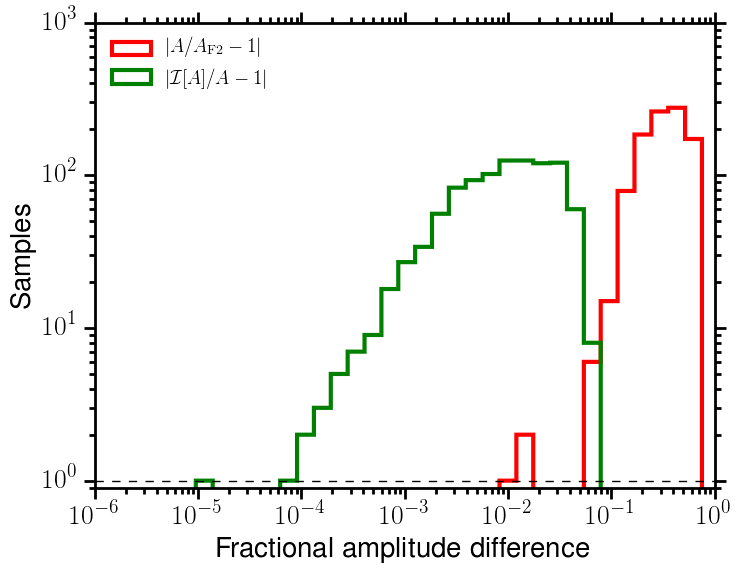

In [135]:
nsamp = len(phase_err)
print nsamp

fig, axes = plt.subplots(1, figsize=(8, 6))

axes.hist(np.abs(amp_rand/amp_f2_rand-1.0), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$|A/A_{\rm F2}-1|$')

axes.hist(np.abs(amp_err), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, 
          label=r'$|\mathcal{I}[A]/A-1|$')

axes.axhline(1.0, c='k', ls='--')
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([1.0e-6, 1.0])
axes.set_ylim([0.9, 1000])
axes.set_xlabel('Fractional amplitude difference')
axes.set_ylabel('Samples')
axes.legend(loc='upper left', frameon=False)

1000


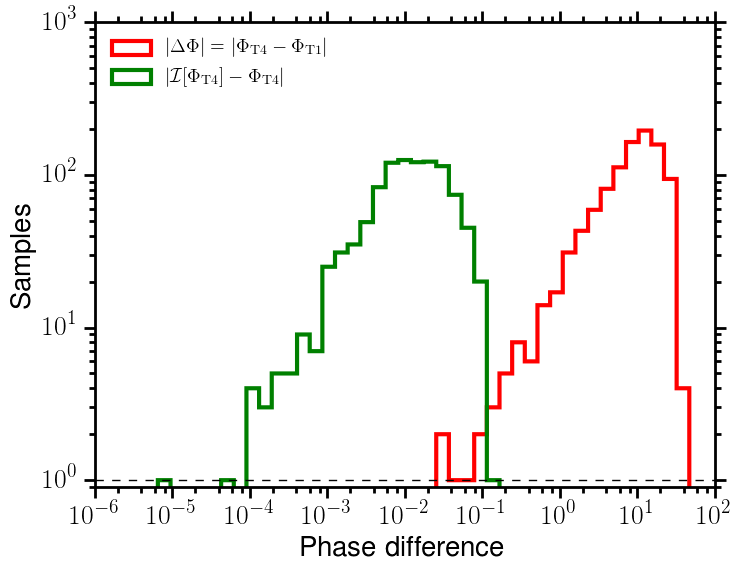

In [131]:
nsamp = len(phase_err)
print nsamp

fig, axes = plt.subplots(1, figsize=(8, 6))

axes.hist(np.abs(phi_rand-phase_f2_rand), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$|\Delta\Phi| = |\Phi_{\rm T4}-\Phi_{\rm T1}|$')

axes.hist(np.abs(phase_err), bins=np.logspace(-6, 2, 50), histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, 
          label=r'$|\mathcal{I}[\Phi_{\rm T4}]-\Phi_{\rm T4}|$')

axes.axhline(1.0, c='k', ls='--')
axes.set_xscale("log")
axes.set_yscale("log")
#axes.set_xlim([1.0e-4, 100.0])
axes.set_ylim([0.9, 1000])
axes.set_xlabel('Phase difference')
axes.set_ylabel('Samples')
axes.legend(loc='upper left', frameon=False)